In [1]:
"""
https://tradingstrategyguides.com/swing-trading-strategies-that-work/

It's based on classic technical indicator called "Bollinger Bands". It's construced as:
- central moving average (MA), which is a simple moving average.
- two other moving averages at a distance of +-2 standard dev. away from the central MA

There are following steps:
#1: Wait for the price to touch the Upper Bollinger Band. It (in theory) means that price is price moving into 
overbought territory. That is - price is relatively too high for given stock and will probably go down.

Step #2: Wait for the price to Break below the Middle Bollinger Bands. Such a move acts as confirmation of the 
shift in market sentiment. In other words - investors realized that stock is overbought and started seeling
(hence price is going down).

Important Note: the "breakout" of the central MA should be so called "Big Bold Breakout Candle". That is
closing price is near the Low Range of the Candlestick. One should sell at the closing price of the Breakout Candle.

This "Breakout Candle" is meant to confirm that there are real sellers, that is: there is an assumption that such a
strong move down indicates actual changed sentiment of sellers rather that just its the "natural" fluctation 
of the price.

Step #4: Set-up "Protective Stop Loss" above the Breakout Candle
As a stop loss high of the entry candle is taken. Rationalities behind it is that during entry move one assumes 
candle as representation of real market sentiment and sellers. If high of this candle is "broken" that is
clear sign that in this case there was no real sellers sentiment shift.

Step #5: Take Profit once we break and close back above the middle Bollinger Bands (central MA)

THAT WAS SHORT TRADE EXAMPLE. FOR LONG TRADES THERE ARE SAME STEPS BUT IN REVERSED ORDER

My personal thought:
- It would be nice to have some sort of expected range of the move. That is - one is setting up stop loss which is 
fine, but at the same time there is no expected range of the move in preferable direction. That makes calculating
reward-to-risk ratio imposibble.
- If one have multiple trades to choose (and properly diversify portfolio) then given strategy gives no clues about
which trade choose. R2R ratio would be helpfull.
- That problem occures not only when we have couple of trades to choose in the same day. One can "loose" future trade
by choosing the one today - which in reality one is not aware of having small R2RR.
- Having method to estimate R2RR and uses it as an additional filter for trades could be good enhacemnet for that
strategy.

""";



"""
"Big Bold Candle" is actually really unclear. In the article it is mentioned that is should have (for short) 
"closing price is near the Low Range of the Candlestic". The thing is that "Low Range" is the thin line below the 
body - it's also called "wick" or "shadow". But in what sense it's big? Closing price may be  near lowest price but 
the whole price range (from high to low - indication of volatility) may be really "small"...
I could not find any canlde formation actually called "big bold...". I think authours could refer to 2 formations
called "Big Black Candle" and "Big White Candle". Thoe are candles with long bodies. 

Big Black Candle - Has an unusually long black body with a wide range between high and low. Prices open near the
high and close near the low. Considered a bearish pattern.

Big White Candle - Has an unusually long white body with a wide range between high and low of the day. Prices open 
near the low and close near the high. Considered a bullish pattern.

The problem with those definitions is - what it means "unusually long (...) body"? How to quantify that? I could
not find anything more specific than adjectives like "long", "big" etc...

I'd say it should be parametrized somewhow... Or taken from distibution of ranges from the past... I imagine 
that "long" candles may be for stocks quite "normal" where for the others they are super rare. 

As a proxy distribution I can take average range and standard deviation in last X days. It may be the same period
I'm taking for moving average or the other. Then I can see how many standard deviations from average given candle's
range is. If it's above certain threshold - consider it as "big".
""";

In [88]:
# built-in
from itertools import islice
import sys
sys.path.insert(0, '/Users/slaw/osobiste/trading')

# 3rd party
import numpy as np
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import scipy.stats as stats

# custom
import gpw_data
import strategies.helpers as helpers
import backtester
import position_size
import results

# to allow zoom plots
%matplotlib notebook  

In [36]:
import importlib
importlib.reload(gpw_data);
importlib.reload(backtester);
importlib.reload(helpers);
importlib.reload(results);

In [4]:
gpwdata = gpw_data.GPWData(pricing_data_path='../pricing_data')
wig_20_stocks = gpwdata.load(index='WIG20')

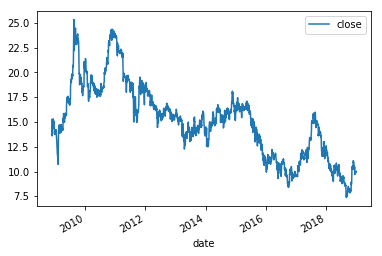

In [5]:
# tests for single stock for now
symbol = wig_20_stocks['ENEA']
# symbol = wig_20_stocks['CCC']
symbol.plot(y=['close']);

In [120]:
def generate_signals(df, ma_type='simple', time_window=20, no_std=2):
    df = df.copy()
    
    # 1) bollinger_bands
    df = helpers.create_bollinger_bands(symbol, ma_type=ma_type, time_window=time_window, no_std=no_std)
    
    # 2) find breakout candles ("Big Bold Candels" from the strategy description)
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    # 3) # Overbought and oversold regimes
    upper_diff_idx0 = abs(df['upper_ma'].iloc[0] - df['close'].iloc[0])
    lower_diff_idx0 = abs(df['lower_ma'].iloc[0] - df['close'].iloc[0])
    if upper_diff_idx0 >= lower_diff_idx0:
        first_period = 'L'
    elif upper_diff_idx0 < lower_diff_idx0:
        first_period = 'U'
    df.loc[:, 'previous_period'] = ''
    df.at[df.index[0], 'previous_period'] = first_period
    df.replace('', np.nan, inplace=True)
    
    # df.loc[:, 'previous_period'] = np.where(df['close'] <= df['lower_ma'], 'L', df['previous_period'])
    # df.loc[:, 'previous_period'] = np.where(df['close'] >= df['upper_ma'], 'U', df['previous_period'])
    
    df.loc[:, 'previous_period'] = np.where(
        ((df['close'] <= df['lower_ma']) | (df['open'] <= df['lower_ma'])),
        'L', df['previous_period']
    )
    df.loc[:, 'previous_period'] = np.where(
        ((df['close'] >= df['upper_ma']) | (df['open'] >= df['upper_ma'])),
        'U', df['previous_period']
    )
    
    
    df['previous_period'].fillna(method='ffill', inplace=True)
    
    # 4) *for debuging* get first/last dates for Overbought/oversold periods
    overbought = []
    oversold = []
    prev = first_period
    prev_idx_int = 0
    idx_int = 1
    for idx, row in islice(df.iterrows(), 1, None):
        cur = row['previous_period']
        if prev == 'U' and cur == 'L':
            overbought.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        elif prev == 'L' and cur == 'U':
            oversold.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        if prev == cur:
            idx_int += 1
            continue
        idx_int += 1
        
    # 5) GENERATE ENTRY AND EXIT SIGNALS
    df.loc[:, 'entry_long'] = 0
    df.loc[:, 'entry_short'] = 0
    df.loc[:, 'exit_long'] = 0
    df.loc[:, 'exit_short'] = 0
    df.loc[:, 'stop_loss'] = np.nan
    # helper tracking variable to correctly set up things
    _long_position = 0
    _short_position = 0
    _long_above_cma = 0
    _short_below_cma = 0
    _stop_loss = 0
    for i, row in df.iterrows():
        # entries
        entry_long_signal = (row['is_long'] == True) and (row['close'] > row['open']) and (row['previous_period'] == 'L')
        entry_short_signal = (row['is_long'] == True) and (row['close'] < row['open']) and (row['previous_period'] == 'U')
        
        if (entry_long_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_long'] = 1
            _long_position = 1
            _stop_loss = row['low']
        elif (entry_short_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_short'] = 1
            _short_position = 1
            _stop_loss = row['high']
        
        # exits
        exit_long_signal = (row['close'] <= row['central_ma']) and _long_above_cma == 1
        exit_short_signal = (row['close'] >= row['central_ma']) and _short_below_cma == 1
        if exit_long_signal and _long_position == 1:
            df.at[i,'exit_long'] = 1
            _long_position = 0
            _long_above_cma = 0
        elif exit_short_signal and _short_position == 1:
            df.at[i,'exit_short'] = 1
            _short_position = 0
            _short_below_cma = 0
            
        # set up crossing middle central moving average
        if _long_position == 1 and row['open'] > row['central_ma']:
            _long_above_cma = 1
        elif _short_position == 1 and row['open'] < row['central_ma']:
            _short_below_cma = 1
        # roll over stop loss
        if _long_position == 1 or _short_position == 1:
            df.at[i,'stop_loss'] = _stop_loss
            
    # 6) *for debuging* get long and short trades periods
    long_periods, short_periods = helpers.gather_entry_exist_signals_dates(df)
    
    return {
        'df': df,
        'long_periods': long_periods,
        'short_periods': short_periods,
        'overbought_periods': overbought,
        'oversold_periods': oversold,
    }

    
df_with_signals = generate_signals(
    symbol,
    ma_type='simple',
    time_window=20,
    no_std=2
)
print(df_with_signals['df'].head(28))
    

             open   high    low  close  volume  central_ma    ma_std  \
date                                                                   
2008-12-12  15.00  15.10  15.00  15.06    9074     14.7020  0.524842   
2008-12-15  15.00  15.14  15.00  15.00   18038     14.6895  0.513968   
2008-12-16  15.00  15.00  14.90  15.00   23185     14.7395  0.491512   
2008-12-17  14.97  14.97  14.25  14.25    9286     14.7500  0.477835   
2008-12-18  14.44  14.44  13.76  13.87    6735     14.7635  0.446416   
2008-12-19  13.87  14.13  13.80  13.90    6118     14.7585  0.455877   
2008-12-22  14.00  14.00  13.75  13.76    7423     14.7265  0.502450   
2008-12-23  13.75  13.80  13.60  13.80   21717     14.6915  0.541890   
2008-12-29  13.90  13.90  13.62  13.79   13527     14.6660  0.572422   
2008-12-30  13.83  13.90  13.71  13.89   33524     14.6430  0.594599   
2008-12-31  14.10  14.20  13.90  14.00   19607     14.6120  0.611776   
2009-01-05  14.21  14.21  14.00  14.08    6105     14.5820  0.62

<IPython.core.display.Javascript object>


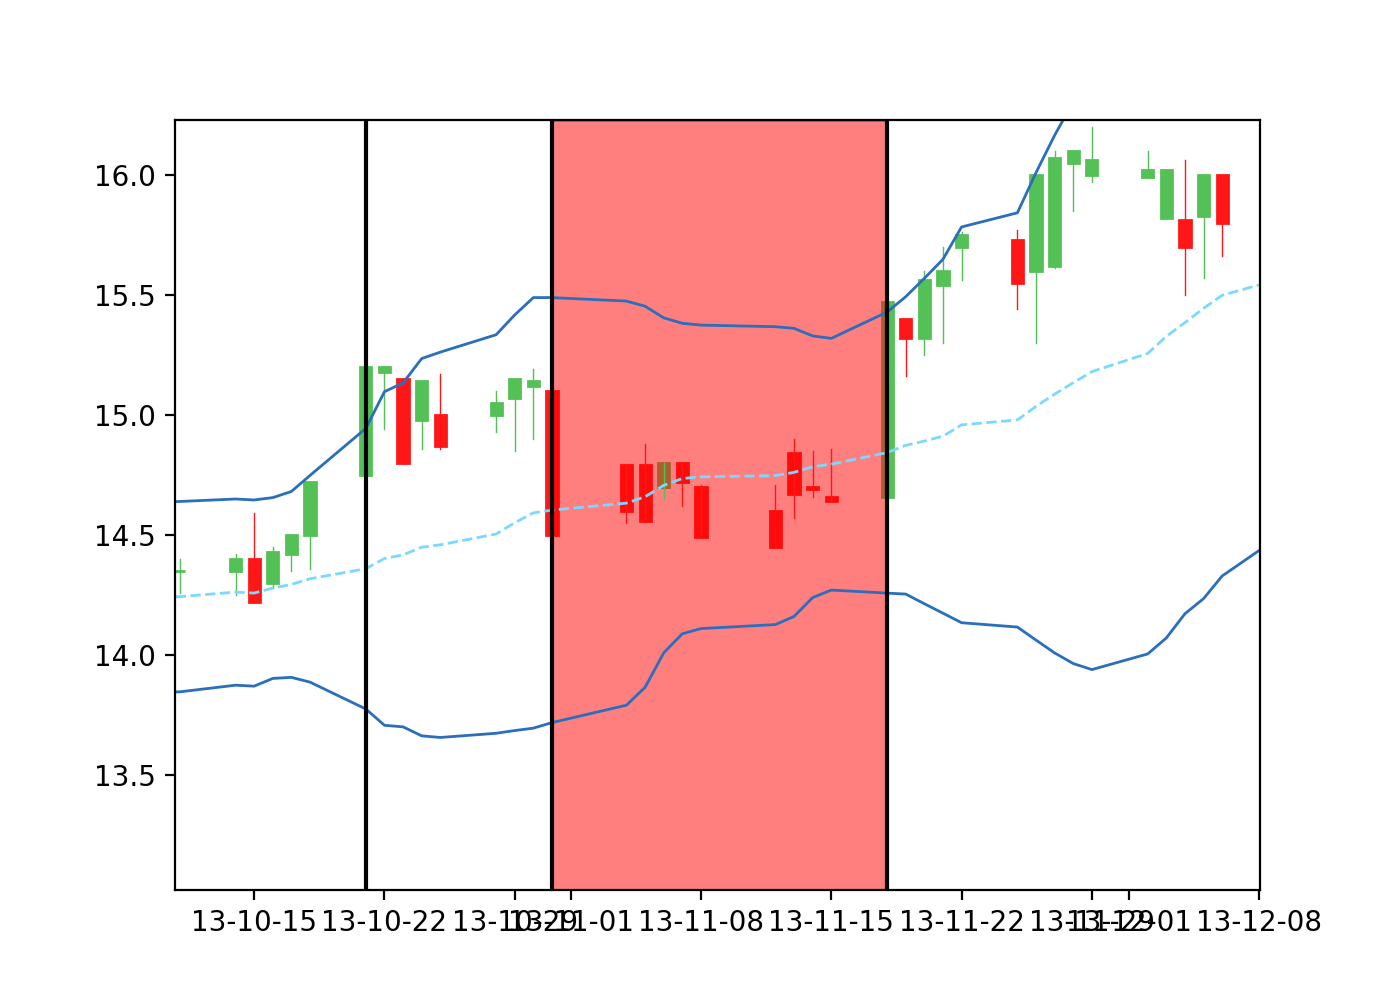

In [121]:
def plot_strategy_signals(
    df=None, ohlc=False, bands=True, close=False, candles=True, long_periods=None, short_periods=None,
    overbought_periods=None, oversold_periods=None
):
    df = df.copy()
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    # candle chart
    if ohlc == True:
        df.loc[:, 'date'] = pd.to_datetime(df.index)
        df.loc[:, 'date'] = df['date'].apply(mdates.date2num)
        df_for_candle = df[['date', 'open', 'high', 'low', 'close']]
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
        candlestick_ohlc(ax, df_for_candle.values, width=.6, colorup='#53c156', colordown='#ff1717')

    # bands, close price and candles
    if bands == True:
        ax.plot(df['central_ma'], color='#7ad9ff', linestyle='--', linewidth=1)
        ax.plot(df['lower_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
        ax.plot(df['upper_ma'], color='#2a6ebc', linestyle='-', linewidth=1)
    if close == True:
        ax.plot(df['close'], color='black', linestyle='-', linewidth=1)
    if candles == True:
        long_candles = df[df['is_long']].index.tolist()
        for c in long_candles:
            ax.axvline(c, color='black', linestyle='-')
    
    # long/short trades periods
    if isinstance(long_periods, list):
        for lp in long_periods:
            ax.axvspan(lp[0], lp[1], alpha=0.5, color='green')
    if isinstance(short_periods, list):
        for sp in short_periods:
            ax.axvspan(sp[0], sp[1], alpha=0.5, color='red')
    
    # overbough and oversold
    if isinstance(overbought_periods, list):
        for obp in overbought_periods:
            ax.axvspan(obp[0], obp[1], alpha=0.5, color='yellow')
    if isinstance(oversold_periods, list):
        for osp in oversold_periods:
            ax.axvspan(osp[0], osp[1], alpha=0.5, color='blue')
    
    plt.show()


plot_strategy_signals(
    df = df_with_signals['df'],
    ohlc = True,
    # candles = False,
    long_periods = df_with_signals['long_periods'],
    short_periods = df_with_signals['short_periods'],
    # overbought_periods = df_with_signals['overbought_periods'],
    # oversold_periods = df_with_signals['oversold_periods'],
)

In [123]:
# Test run of the strategy (still without SL)

# prepare data
symbol_key = 'ENEA'
raw_prices = wig_20_stocks[symbol_key]
test_signals = {
    symbol_key: generate_signals(
        raw_prices,
        ma_type='simple',
        time_window=10,
        no_std=2
    )['df']
}
# signals_test, signals_validation = gpwdata.split_into_subsets(test_signals, 0.5)
# print(signals_validation)

# run backtester
position_sizer = position_size.MaxFirstEncountered()
tester = backtester.Backtester(test_signals, position_sizer=position_sizer, )
tester_results, tester_trades = tester.run()

# calculate results
metrics = results.evaluate(tester_results, tester_trades)

<IPython.core.display.Javascript object>


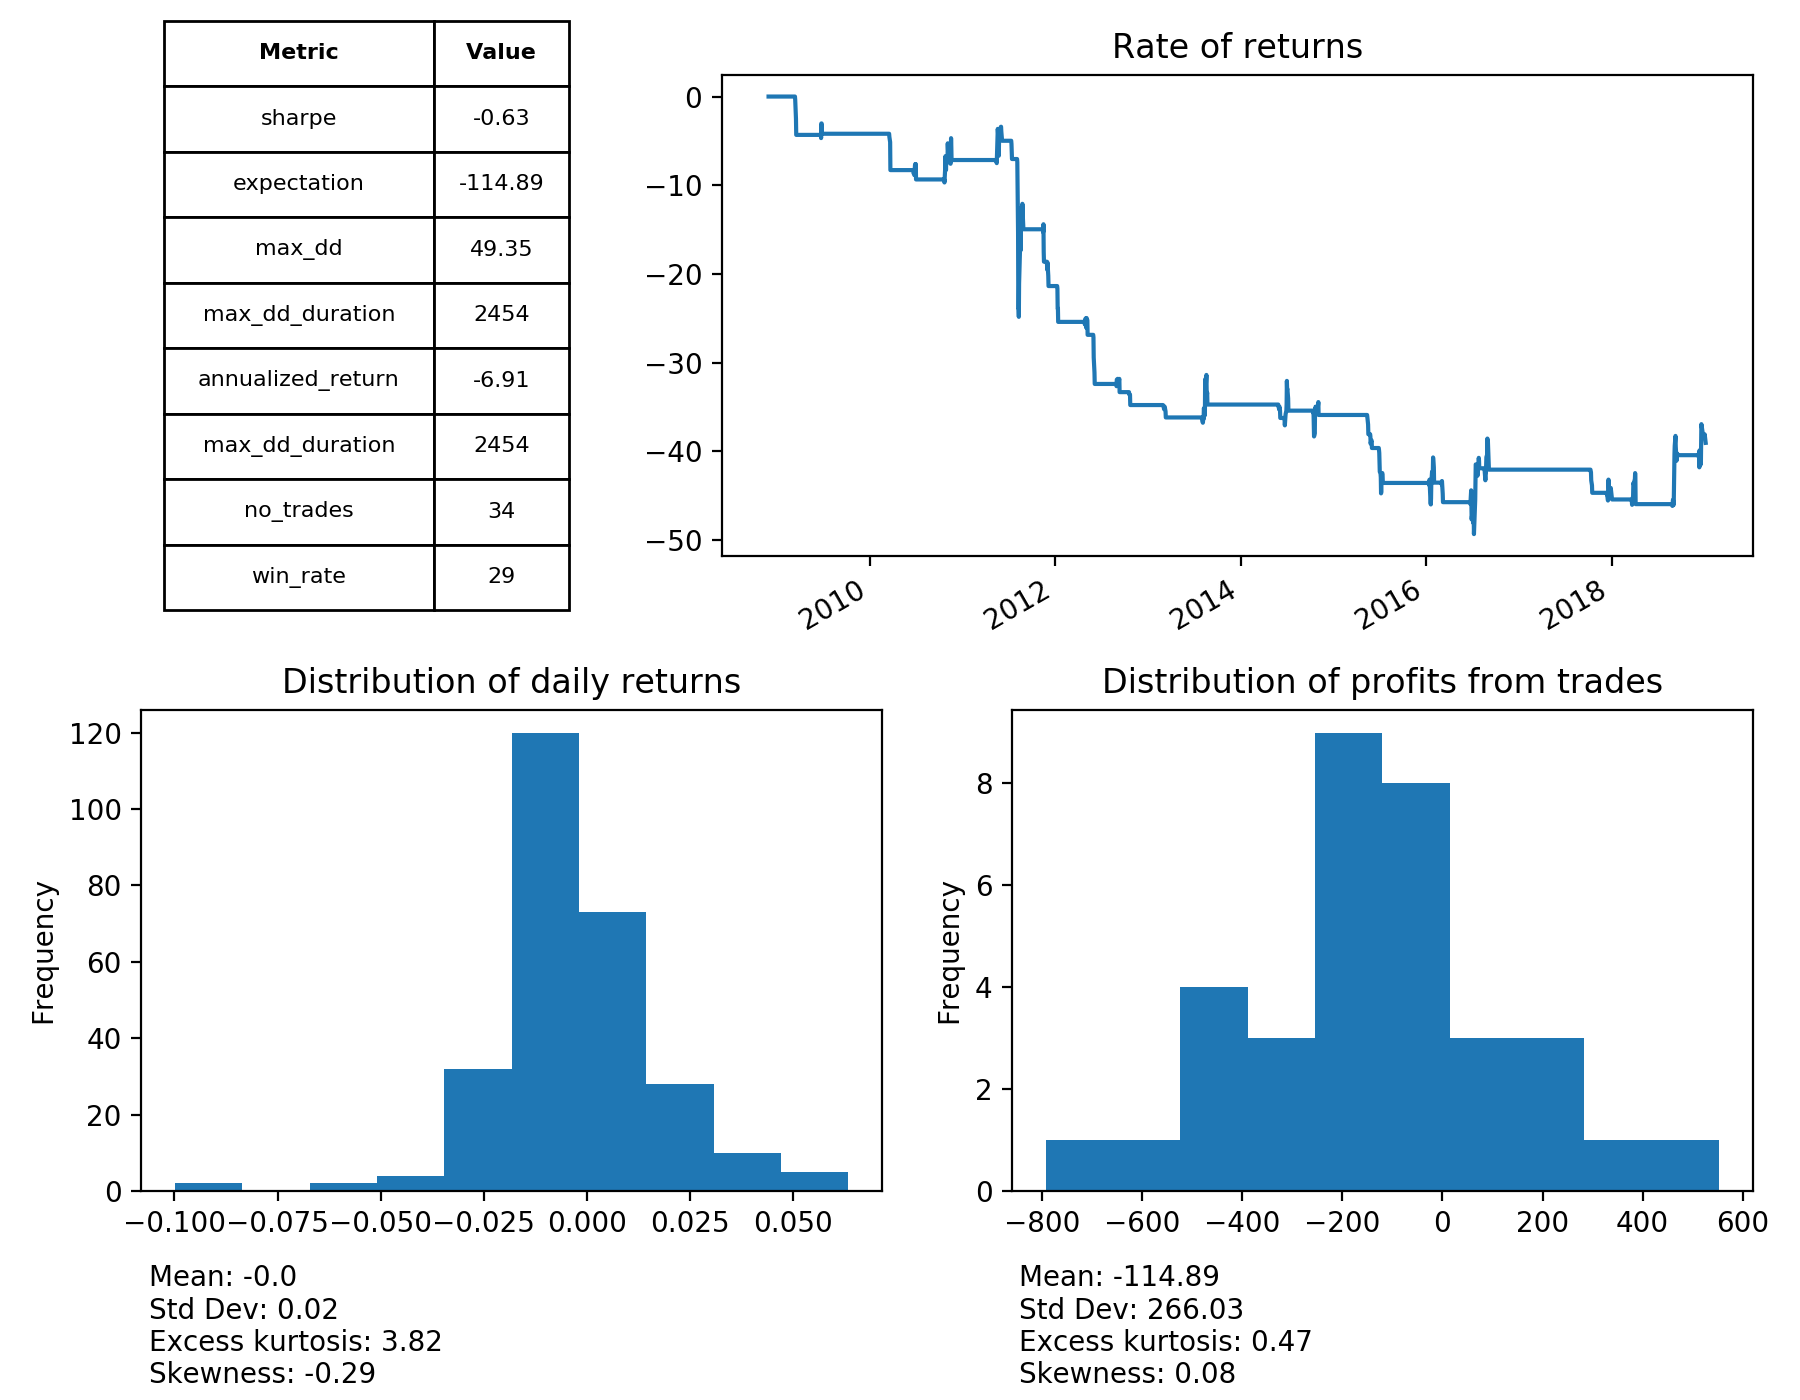

In [124]:
results.performance_report(tester_results, tester_trades)

In [105]:
"""
Strategy TODO;s
OK - clean what you have so far
OK - visual test performance
OK - test strategy as it is so far (Stop Loss in not implemented yet)
OK - test strategy with backtester with Stop Loss
OK - implement stop loss also in signal so that if there was premature entry you can enter again
- debug why are you loosing so much?
- how to define Reward-to-risk ration here?
    
Potential improvements (for later):
    -> how to avoid premature entires/exits?
    -> proxiity to overbought oversold area ("close enough")
    
""";

<IPython.core.display.Javascript object>


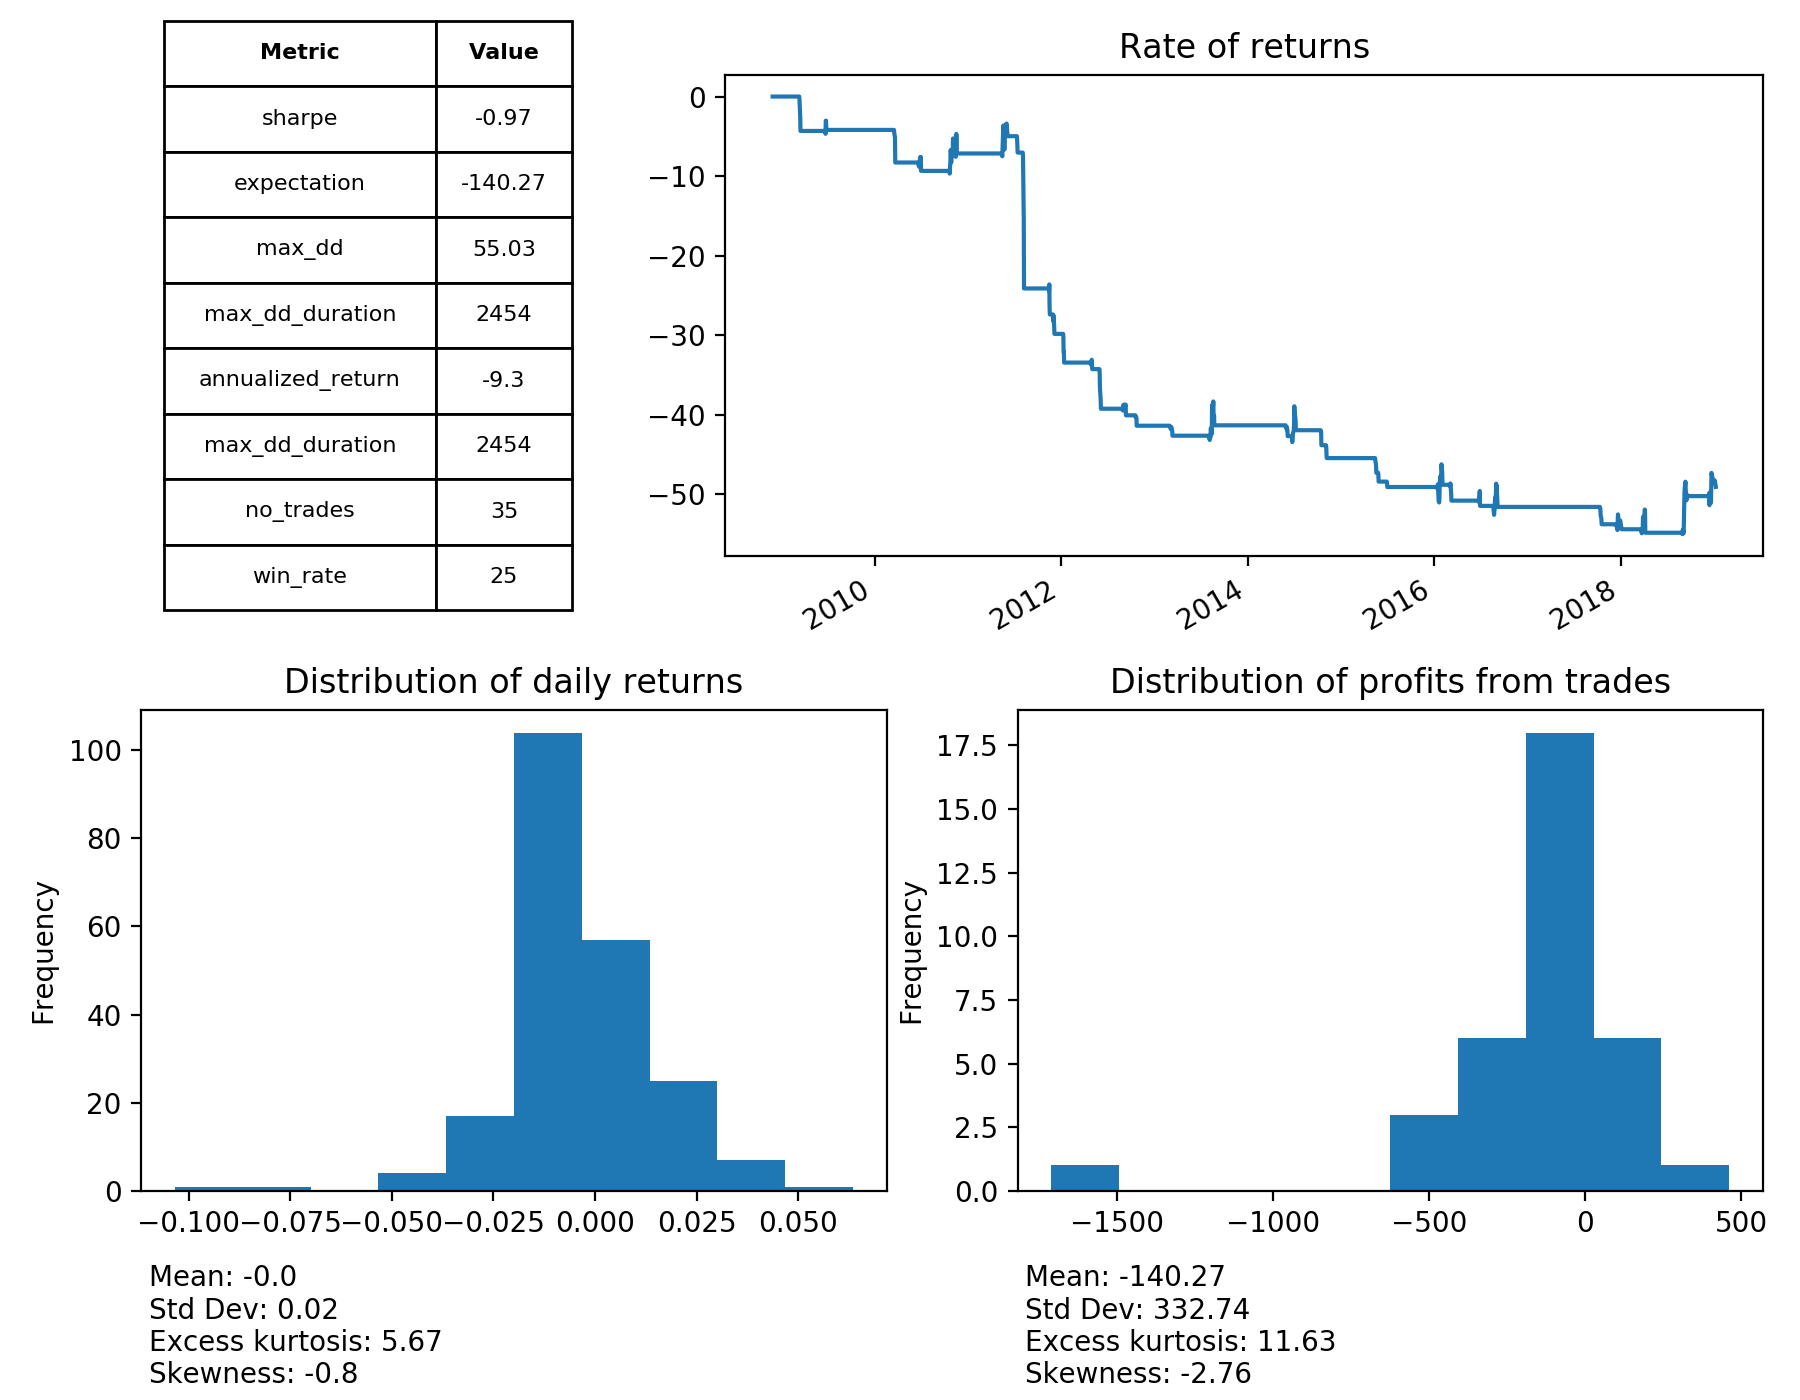

In [110]:
# run backtester
tester_sl = backtester.Backtester(
    test_signals, position_sizer=position_sizer, stop_loss=True,
)
tester_sl_results, tester_sl_trades = tester_sl.run()

results.performance_report(tester_sl_results, tester_sl_trades)

"""
Strategy performs even worse. The reason is that my stategy generates entry signals a little bit too early. SL is
triggered -> trade exited -> and I'm missing some true big moves. I may try to re-enter trades.
""";

In [78]:
"""
Copy paste from orginal function generating signals but this time with re-entering trades after stop loss is triggered.
"""
def generate_signals_re_enter(df, ma_type='simple', time_window=20, no_std=2):
    df = df.copy()
    
    # 1) bollinger_bands
    df = helpers.create_bollinger_bands(symbol, ma_type=ma_type, time_window=time_window, no_std=no_std)
    
    # 2) find breakout candles ("Big Bold Candels" from the strategy description)
    # get lenght of clandles body, it's average and std dev
    df.loc[:, 'candle_range'] = abs(df['close'] - df['open'])
    df.loc[:, 'candle_range_avg'] = df['candle_range'].rolling(window=time_window).mean()
    df.loc[:, 'candle_range_std'] = df['candle_range'].rolling(window=time_window).std()
    # identify "long" candles
    df.loc[:, 'is_long'] = abs(df['candle_range_avg'] - df['candle_range']) > no_std*df['candle_range_std']
    
    # 3) # Overbought and oversold regimes
    upper_diff_idx0 = abs(df['upper_ma'].iloc[0] - df['close'].iloc[0])
    lower_diff_idx0 = abs(df['lower_ma'].iloc[0] - df['close'].iloc[0])
    if upper_diff_idx0 >= lower_diff_idx0:
        first_period = 'L'
    elif upper_diff_idx0 < lower_diff_idx0:
        first_period = 'U'
    df.loc[:, 'previous_period'] = ''
    df.at[df.index[0], 'previous_period'] = first_period
    df.replace('', np.nan, inplace=True)
    df.loc[:, 'previous_period'] = np.where(df['close'] <= df['lower_ma'], 'L', df['previous_period'])
    df.loc[:, 'previous_period'] = np.where(df['close'] >= df['upper_ma'], 'U', df['previous_period'])
    df['previous_period'].fillna(method='ffill', inplace=True)
    
    # 4) *for debuging* get first/last dates for Overbought/oversold periods
    overbought = []
    oversold = []
    prev = first_period
    prev_idx_int = 0
    idx_int = 1
    for idx, row in islice(df.iterrows(), 1, None):
        cur = row['previous_period']
        if prev == 'U' and cur == 'L':
            overbought.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        elif prev == 'L' and cur == 'U':
            oversold.append((df.index[prev_idx_int], df.index[idx_int-1]))
            prev = cur
            prev_idx_int = idx_int
        if prev == cur:
            idx_int += 1
            continue
        idx_int += 1
        
    # 5) GENERATE ENTRY AND EXIT SIGNALS
    df.loc[:, 'entry_long'] = 0
    df.loc[:, 'entry_short'] = 0
    df.loc[:, 'exit_long'] = 0
    df.loc[:, 'exit_short'] = 0
    df.loc[:, 'stop_loss'] = np.nan
    # helper tracking variable to correctly set up things
    _long_position = 0
    _short_position = 0
    _long_above_cma = 0
    _short_below_cma = 0
    _stop_loss = 0
    for i, row in df.iterrows():
        # entries
        entry_long_signal = (row['is_long'] == True) and (row['close'] > row['open']) and (row['previous_period'] == 'L')
        entry_short_signal = (row['is_long'] == True) and (row['close'] < row['open']) and (row['previous_period'] == 'U')
        if (entry_long_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_long'] = 1
            _long_position = 1
            _stop_loss = row['low']
        elif (entry_short_signal == True) and (_long_position == 0) and (_short_position == 0):
            df.at[i,'entry_short'] = 1
            _short_position = 1
            _stop_loss = row['high']
        
        # exits
        exit_long_signal = (row['close'] <= row['central_ma']) and _long_above_cma == 1
        exit_short_signal = (row['close'] >= row['central_ma']) and _short_below_cma == 1
        if (exit_long_signal and _long_position == 1) or (_long_position == 1 and row['close'] <= _stop_loss):
            df.at[i,'exit_long'] = 1
            _long_position = 0
            _long_above_cma = 0
        elif (exit_short_signal and _short_position == 1) or (_short_position == 1 and row['close'] >= _stop_loss):
            df.at[i,'exit_short'] = 1
            _short_position = 0
            _short_below_cma = 0
        
        # set up crossing middle central moving average
        if _long_position == 1 and row['open'] > row['central_ma']:
            _long_above_cma = 1
        elif _short_position == 1 and row['open'] < row['central_ma']:
            _short_below_cma = 1
        
        # roll over stop loss
        if _long_position == 1 or _short_position == 1:
            df.at[i,'stop_loss'] = _stop_loss
            
    # 6) *for debuging* get long and short trades periods
    long_periods, short_periods = helpers.gather_entry_exist_signals_dates(df)
    
    return {
        'df': df,
        'long_periods': long_periods,
        'short_periods': short_periods,
        'overbought_periods': overbought,
        'oversold_periods': oversold,
    }

df_with_signals_2 = generate_signals_re_enter(symbol)
test_signals_2 = {symbol_key: df_with_signals_2['df']}

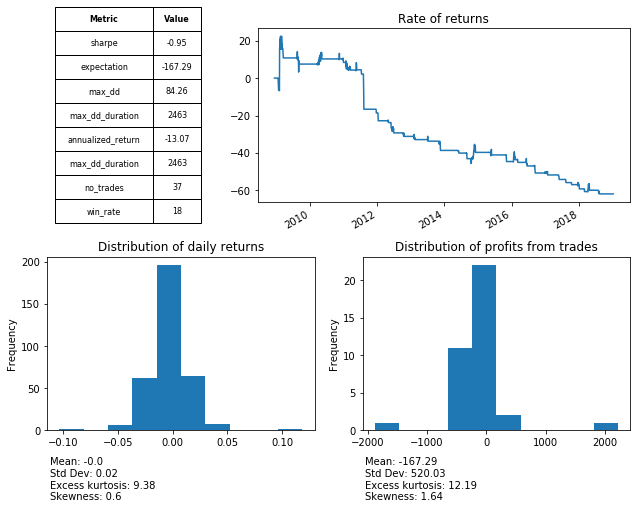

In [52]:
tester_sl_2 = backtester.Backtester(
    test_signals_2,
    position_sizer=position_sizer,
    stop_loss=True,
)
tester_sl_results2, tester_sl_trades2 = tester_sl_2.run()
results.performance_report(tester_sl_results2, tester_sl_trades2)

In [17]:
"""
When re-entering it's not better at all - re-enter just 1 trade. It may be a bug are actual behaviour.
Anyway.... why I'm loosing so much? It looks that:
OK - On average my trades are lossing - it it because wrong entry or too small profits to cover fees?
OK - My SL are not guarding me from big losses. Actually my losses looks pretty much the same with and without SL...
    Why it's that? What's wrong with it?
OK - How many SL are actually triggered?
- Is my re-etnering tactic all right? Should it be on the same rules (big candle etc..)?
""";

<IPython.core.display.Javascript object>


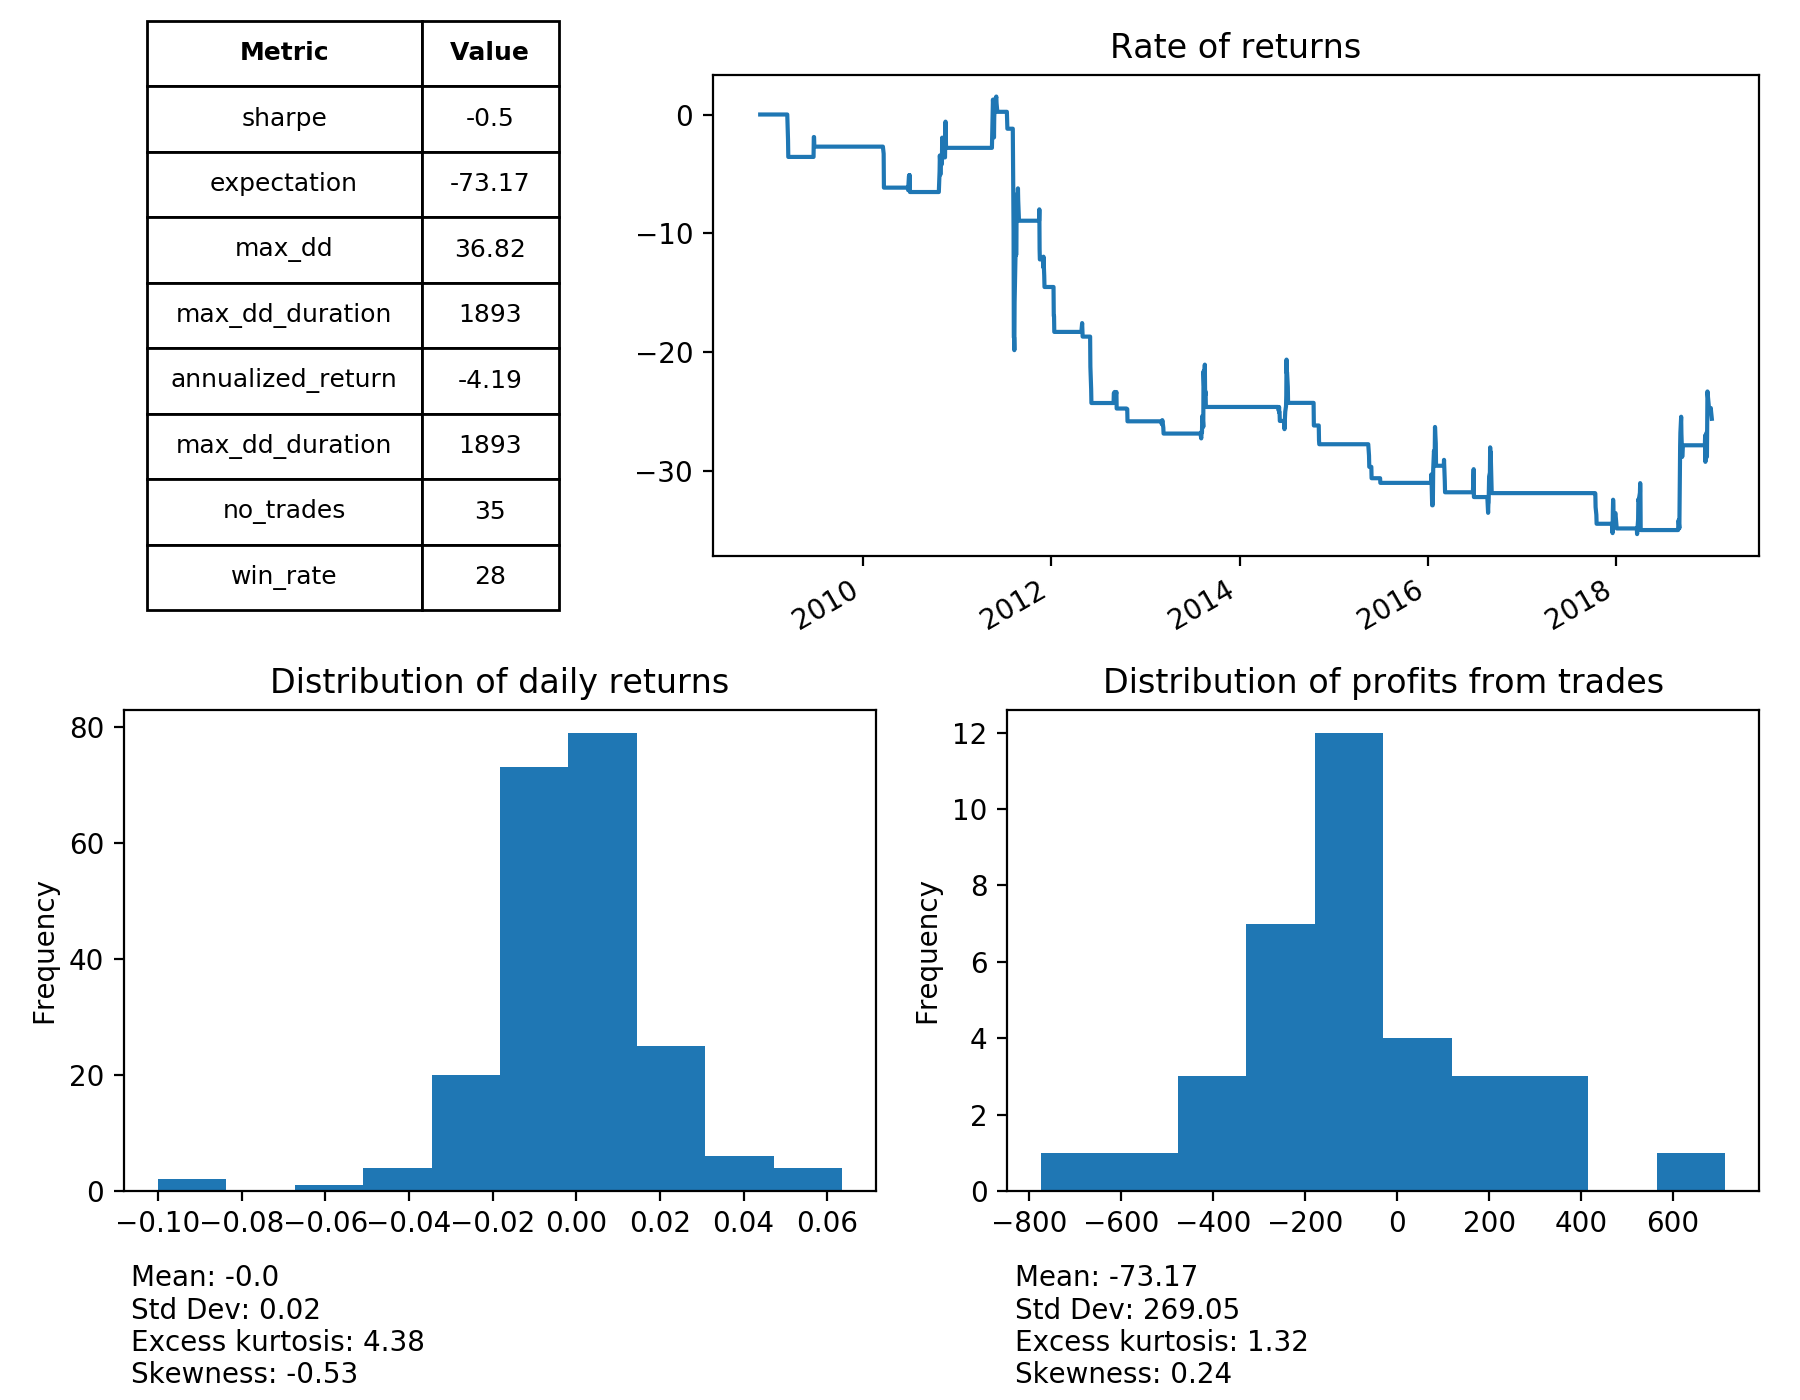

In [111]:
# On average my trades are lossing - it it because wrong entry or too small profits to cover fees?

position_sizer_no_fee = position_size.MaxFirstEncountered(
    min_fee = 0,
    fee_perc = 0.00000000000001
)
tester_no_fees = backtester.Backtester(test_signals, position_sizer=position_sizer_no_fee, )
tester_results_no_fees, tester_trades_no_fees = tester_no_fees.run()

# calculate results
metrics = results.evaluate(tester_results_no_fees, tester_trades_no_fees)
results.performance_report(tester_results_no_fees, tester_trades_no_fees)

"""
Just repeat first strategy iteration without fees... Results are slightly better although I'm still lossing yearly ~10%.
Even without fees I'm regulary loosing money.
""";

In [77]:
longer, shorter = [], []
for idx, trade in enumerate(sorted(tester_trades_no_fees.values(), key=lambda x: x['buy_ds'])):

    _df = test_signals['ENEA']
    
    
    if trade['type'] == 'long':
        profit_perc = (trade['sell_value_no_fee']/trade['trx_value_no_fee'])*100
    elif trade['type'] == 'short':
        profit_perc = (trade['trx_value_no_fee']/trade['sell_value_no_fee'])*100
    profit_perc = int(profit_perc) - 100
    
    # that is not exact as not all dates are session dates
    days_kept = (trade['sell_ds'].date()- trade['buy_ds'].date()).days 
    
    if days_kept <= 10:
        shorter.append(trade['profit'])
    else:
        longer.append(trade['profit'])
    
    
    print(
        '{_type} trade #{num} with profit: {profit} ({perc:+d}%)'.format(
            _type=trade['type'].capitalize(), num=idx+1, profit=trade['profit'], perc=profit_perc
        )
    )
    print('Bought {} units at {}. Kept {} days'.format(
        int(trade['trx_value_no_fee']/_df.loc[trade['buy_ds']]['close']),
        str(trade['buy_ds'].date()), days_kept)
    )
    
    print(
        'Entry value: {}. Value after closed position {}'.format(
            round(trade['trx_value_no_fee'],2 ), round(trade['sell_value_no_fee'], 2)
        )
    )
    
    print(
        _df[(_df.index >= trade['buy_ds']) & (_df.index <= trade['sell_ds'])][['close', 'lower_ma', 'central_ma', 'upper_ma', 'stop_loss']]
    )
    
    print('\n')
    

Short trade #1 with profit: -357.0 (-4%)
Bought 714 units at 2009-03-13. Kept 4 days
Entry value: 9996.0. Value after closed position 10353.0
            close   lower_ma  central_ma   upper_ma  stop_loss
date                                                          
2009-03-13   14.0  13.755425      14.360  14.964575      14.85
2009-03-16   14.3  13.750308      14.356  14.961692      14.85
2009-03-17   14.5  13.830507      14.401  14.971493        NaN


Long trade #2 with profit: 86.55 (+0%)
Bought 577 units at 2009-06-23. Kept 3 days
Entry value: 9635.9. Value after closed position 9722.45
            close   lower_ma  central_ma   upper_ma  stop_loss
date                                                          
2009-06-23  16.70  16.622823      16.925  17.227177       15.5
2009-06-24  16.99  16.626674      16.918  17.209326       15.5
2009-06-25  16.99  16.638829      16.907  17.175171       15.5
2009-06-26  16.85  16.649564      16.882  17.114436        NaN


Long trade #3 with pr

In [73]:
# ?
# I'm entering too early or closing too soon. That is - trades are too short to get profit. Also short trades 
# are looser as exit signal was triggered very fast (false entry signal)
# longer = longer[1:]
for t in ('longer', 'shorter'):
    p = longer if t == 'longer' else shorter
    print('{} trades profits: {}'.format(t, p))
    print('mean: ', np.mean(p))
    print('count overall: ', len(p))
    print('count positive: ', len([x for x in p if x > 0]))
    print('\n')
"""
I see no significat difference between profits of trades kept longer or shorter. Mean profit is bigger for long trades
but that is only due to 1 outlier - trade with more than 1k profit. If one exclude this trade - average proifit 
for trades kept longer is even smaller than the one for trades kept shorter amount of time
""";

longer trades profits: [-242.76, 354.69, -335.34, -833.75, -250.2, -146.9, -553.87, 490.06, 242.74, -120.25, -1438.77, 169.4, -367.57, -79.95, -231.61, 123.25, -278.3]
mean:  -205.83117647058825
count overall:  17
count positive:  5


shorter trades profits: [-405.0, 92.0, -113.04, 96.22, -153.36, -159.9, -426.72, -44.64, -286.5, -163.68, -42.91, -120.75, -323.2, -122.43, -180.67, -538.08, -154.37, -89.25, -136.8]
mean:  -172.26736842105265
count overall:  19
count positive:  2




In [74]:
# ?
# Am I loosing on short trades? Or long ones? Or for both?
long_trades, short_trades = [], []
for t in tester_trades_no_fees.values():
    if t['type'] == 'long':
        long_trades.append(t['profit'])
    elif t['type'] == 'short':
        short_trades.append(t['profit'])
        
print('Long trades profits: {}'.format(long_trades))
print('mean: ', np.mean(long_trades))
print('count overall: ', len(long_trades))
print('count positive: ', len([x for x in long_trades if x > 0]))
print('\n')

print('Short trades profits: {}'.format(short_trades))
print('mean: ', np.mean(short_trades))
print('count overall: ', len(short_trades))
print('count positive: ', len([x for x in short_trades if x > 0]))
print('\n')

"""
No significant difference at the first sight. It looks like trades profits are from very similar distributions.
Means and counts are similar as well as magnitudes of each profits. 
""";

Long trades profits: [1349.58, -335.34, 96.22, -153.36, -833.75, -159.9, -426.72, -44.64, -286.5, -250.2, -163.68, -42.91, 490.06, -1438.77, 169.4, -122.43, -180.67, -367.57, -538.08, -89.25, -136.8, 123.25, -278.3]
mean:  -157.40695652173915
count overall:  23
count positive:  5


Short trades profits: [-405.0, -242.76, 354.69, 92.0, -113.04, -146.9, -553.87, -120.75, -323.2, 242.74, -120.25, -79.95, -154.37, -231.61]
mean:  -128.73357142857142
count overall:  14
count positive:  3




In [ ]:
# My SL are not guarding me from big losses. Actually my losses looks pretty much the same with and without SL...
# Why it's that? What's wrong with it? Also... How many stop losses were triggered anyway?

"""
Stop losses will be rarly triggered. That is due to the way strategy is implemented. 
The part we I set up "crossing central moving average" in most cases creates situation where I will exit
as I would "get the profits" before hitting SL.

In general - the reason this strategy is winning is:
- not enough profits from winning trades with win rate - 20%
In the oter words - I'm loosing 80% of times and not making enough money in cases where I'm winning.


Ideas of what can help:
- changing the way my exit work - right now it causes that trades are exited too early
(that should reduce the losses from too early exits)

- changing "overbought" and "oversold" regime definition (hitting upper band is strick)
(that should increase the number of opportunities)

"""